## Анализ комбинированной модели с помощью weightwatcher

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! pip uninstall numba -y && pip install numba

In [3]:
import os
import sys

# Получаем абсолютный путь к корневой директории проекта (директория выше текущей)
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Добавляем корневую директорию в sys.path
if root_path not in sys.path:
    sys.path.append(root_path)

In [4]:
from model_loaders import load_ss_model
import weightwatcher as ww
from pipeline import separate_audio
import torch
from models.clap_encoder import CLAP_Encoder
import IPython.display as ipd
from utils import parse_yaml
from utils import describe_weights
from torch import nn
import numpy as np
import pandas as pd

2024-05-04 21:15:15.490802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 21:15:15.490831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 21:15:15.491737: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 21:15:15.496142: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 21:15:16.013048: W tensorflow/compiler/tf2

In [5]:
SS_CONFIG_PATH = '../config/audiosep_base.yaml'
CLAP_CKPT_PATH = '../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt'
AUDIOSEP_CKPT_PATH = '../checkpoint/audiosep_base_4M_steps.ckpt'
classes = ["bass", "drums", "vocals", "other musical instruments"]
device = torch.device('cuda')
configs = parse_yaml(SS_CONFIG_PATH)

In [6]:
query_encoder = CLAP_Encoder(pretrained_path = CLAP_CKPT_PATH).eval().to(device)
base_model = load_ss_model(configs=configs, checkpoint_path=AUDIOSEP_CKPT_PATH, query_encoder=query_encoder).eval().to(device)

2024-05-04 21:15:19,324 - INFO - Loading HTSAT-base model config.
2024-05-04 21:15:21,444 - INFO - Loading pretrained HTSAT-base-roberta weights (../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt).


In [7]:
from models.audiosep_lora_and_tuned_embeddings import AudioSepLoraAndTunedEmbeddings

checkpoint_path = '../checkpoints/final/musdb18/lora_embeddings/final.ckpt'

query_encoder_for_lora = CLAP_Encoder(pretrained_path = CLAP_CKPT_PATH).eval().to(device)
base_model_for_lora = load_ss_model(configs=configs, checkpoint_path=AUDIOSEP_CKPT_PATH, query_encoder=query_encoder_for_lora).eval().to(device)

lora_model = AudioSepLoraAndTunedEmbeddings.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    strict=False,
    pretrained_audiosep_model = base_model_for_lora,
    loss_function=None,
    waveform_mixer=None,
    lr_lambda_func=None
) \
    .eval() \
    .to(device)

merged_lora_model = lora_model.model.merge_and_unload()

merged_lora_model.query_encoder = lora_model.model.query_encoder

2024-05-04 21:47:11,076 - INFO - Loading HTSAT-base model config.
2024-05-04 21:47:12,388 - INFO - Loading pretrained HTSAT-base-roberta weights (../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt).


# Ранг слоев затюненой модели

In [8]:
from utils import calculate_ranks_of_conv_layers

# Вызываем функцию для расчета рангов
ranks = calculate_ranks_of_conv_layers(merged_lora_model.ss_model)
ranks

,layer_name,lower_dim_size,rank
0,base->pre_conv,1,1
1,base->encoder_block1->conv_block1->conv1,32,32
2,base->encoder_block1->conv_block1->conv2,32,32
3,base->encoder_block2->conv_block1->conv1,64,64
4,base->encoder_block2->conv_block1->conv2,64,64
5,base->encoder_block2->conv_block1->shortcut,32,32
6,base->encoder_block3->conv_block1->conv1,128,128
7,base->encoder_block3->conv_block1->conv2,128,128
8,base->encoder_block3->conv_block1->shortcut,64,64
9,base->encoder_block4->conv_block1->conv1,256,256


Ранги остались неизменными

# Посмотрим на среднее alpha затюненой separation net

{'log_norm': 3.462629987699735, 'alpha': 3.559142605964055, 'alpha_weighted': 6.686196478312739, 'log_alpha_norm': 7.170253291363401, 'log_spectral_norm': 2.190367225337929, 'stable_rank': 39.93732140427164}


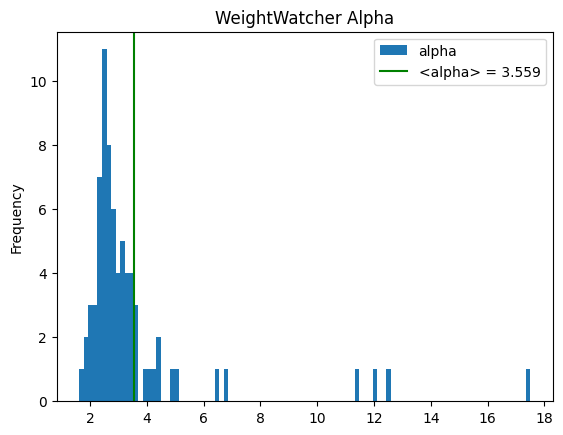

In [9]:
from utils import plot_hist

base_details, base_summary = describe_weights(merged_lora_model.ss_model)
plot_hist(base_details)
print(base_summary)

Видим, что стало меньше недообученных слоев, но среднее alpha незначительно увеличилось, посмотрим, какие слои были затронуты наиболее сильно и как изменилось alpha конкретного слоя

In [10]:
watcher = ww.WeightWatcher()
avg_dW, avg_db, distances = watcher.distances(base_model.ss_model, merged_lora_model.ss_model)
display((avg_dW, avg_db))
conv_distances = distances[distances['name']=='Conv2d']
conv_distances[['longname', 'delta_W']].sort_values('delta_W', ascending=False)

(2.0, 0.0)

,longname,delta_W
layer_id,,
54,base.conv_block7a.conv_block1.conv1,13.726562
55,base.conv_block7a.conv_block1.conv2,12.640625
48,base.encoder_block6.conv_block1.conv1,10.554688
62,base.decoder_block1.conv_block2.conv1,10.375000
42,base.encoder_block5.conv_block1.conv2,9.820312
72,base.decoder_block2.conv_block2.conv1,9.296875
49,base.encoder_block6.conv_block1.conv2,8.843750
35,base.encoder_block4.conv_block1.conv2,8.085938
83,base.decoder_block3.conv_block2.conv2,7.929688


In [11]:
max_level = 2
# Группировка по блокам
df_split = conv_distances['longname'].str.split('.', expand=True)
df_expanded = pd.concat([df_split, conv_distances['delta_W']], axis=1)

for level in range(max_level):  # Исключаем колонку 'value'
    grouped_df = df_expanded.groupby(list(range(level + 1))).sum().reset_index()
    grouped_df = grouped_df.sort_values(by='delta_W', ascending=False)
    print(f"Группировка по уровню {level + 1}:\n", grouped_df, "\n")

Группировка по уровню 1:
       0     delta_W
0  base  148.054749 

Группировка по уровню 2:
        0               1    delta_W
0   base    conv_block7a  26.367188
2   base  decoder_block2  19.654297
12  base  encoder_block6  19.398438
1   base  decoder_block1  19.025391
11  base  encoder_block5  17.897461
3   base  decoder_block3  16.601562
10  base  encoder_block4  13.846680
4   base  decoder_block4   5.443359
9   base  encoder_block3   5.104492
8   base  encoder_block2   2.055420
5   base  decoder_block5   1.711182
7   base  encoder_block1   0.627686
6   base  decoder_block6   0.321594 



Видим, что больше всего подверглись дообучению центральные слои - последние слои энкодера, ботлнек и первые слои декодера. Причем в отличие от простого применения lora средняя дельта несколько больше. Также наибольшим образом поменялся ботлнек, в то время как в lora методе больше всего менялся декодер

In [12]:
base_details, _ = describe_weights(base_model.ss_model)
lora_details, _ = describe_weights(merged_lora_model.ss_model)
base_details = base_details[['longname', 'alpha', 'warning']]
lora_details = lora_details[['longname', 'alpha', 'warning']]

In [13]:
concat_df = pd.concat([base_details.add_prefix('base_'), lora_details.add_prefix('tuned_')], axis=1)
concat_df['change'] = concat_df['base_alpha'] - concat_df['tuned_alpha']
print(f'min change: {concat_df["change"].min()}', f'max change: {concat_df["change"].max()}')
concat_df[['base_longname', 'base_alpha', 'tuned_alpha', 'change', 'base_warning', 'tuned_warning']].sort_values('change')

min change: -2.5685888640257994 max change: 0.07846785444448257


,base_longname,base_alpha,tuned_alpha,change,base_warning,tuned_warning
1,base.encoder_block1.conv_block1.conv2,2.261872,4.830461,-2.568589,,
10,base.encoder_block4.conv_block1.shortcut,4.369195,6.739958,-2.370763,,under-trained
12,base.encoder_block5.conv_block1.conv2,2.932252,4.281898,-1.349646,,
32,base.decoder_block5.conv_block2.shortcut,1.591179,1.853530,-0.262351,over-trained,over-trained
29,base.decoder_block4.conv_block2.shortcut,2.953070,3.006816,-0.053746,,
...,...,...,...,...,...,...
26,base.decoder_block3.conv_block2.shortcut,3.947977,3.923631,0.024347,,
7,base.encoder_block3.conv_block1.shortcut,2.911052,2.875800,0.035251,,
9,base.encoder_block4.conv_block1.conv2,4.159504,4.123019,0.036485,,
27,base.decoder_block4.conv_block2.conv1,3.414826,3.357261,0.057565,,


Видим что три слоя в encoder сильно ухудшили свою обобщающую способность, как и в методе lora один из skip-connection стал under-trained

{'log_norm': 3.133355609006751, 'alpha': 4.508056021992094, 'alpha_weighted': 6.417085302626215, 'log_alpha_norm': 6.761804573165426, 'log_spectral_norm': 1.5909656086545398, 'stable_rank': 43.472797077236216}


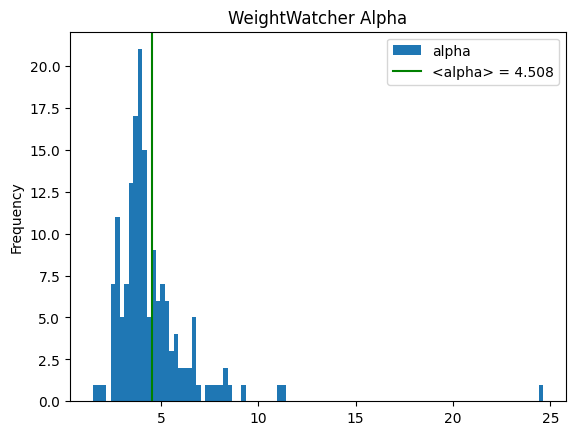

In [14]:
from utils import plot_hist

base_details, base_summary = describe_weights(merged_lora_model.query_encoder)
plot_hist(base_details)
print(base_summary)

In [15]:
ckpt = torch.load(checkpoint_path)['state_dict']
ckpt = {layer: weight for layer, weight in ckpt.items() if 'tuned_embedding' in layer}

In [16]:
details, _ = describe_weights(ckpt)
details[['longname', 'alpha', 'warning']]

,longname,alpha,warning
0,model.query_encoder.tuned_embedding_layer.0,3.216923,
1,model.query_encoder.tuned_embedding_layer.2,6.748266,under-trained


Результат натренированности слоев отличается от метода embeddings в худшую сторону в обоих слоях. Это можно объяснить тем, что часть файн-тюнинга на себя забрала lora.